# Estimate polarization from raytracing and compare to reco pol

#### Reco pol is now done by using the same window for both hpol and vpol

### Mar 3, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

In [3]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

#### From Dave Besson, the cross pol is of about 25%, and it's due to the transmitter beam pattern.

## Expected polarization 

In [128]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    path2 = rt.solutions[1] #We only care about direct solutions

    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    polFinal = newOmegaPol-np.degrees(rotAngle)
    return polFinal, np.degrees(rt.solutions[0].theta0),np.degrees(np.arccos(path.received_direction[2])),np.degrees(np.arccos(path2.received_direction[2]))

In [149]:
rt = pyrex.RayTracer(from_point=(0, 0, -500), to_point=(2400, 0, -179.93))

In [150]:
path = rt.solutions[0]
path2 = rt.solutions[1]
arr_ang = np.degrees(np.arccos(path.received_direction[2]))

IndexError: list index out of range

In [82]:
theta_d=np.degrees(np.arccos(path.received_direction[2])-np.pi/2)
theta_r=np.degrees(np.arccos(path2.received_direction[2])-np.pi/2)

(-1500, 0)

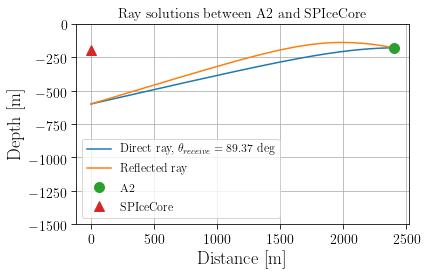

In [146]:
fig, ax1 = plt.subplots(figsize=(6,4))

# plt.plot(path.coordinates[0],path.coordinates[2], label="Direct ray ($\\theta_d =%0.1f^\circ$)"% theta_d)
# plt.plot(path2.coordinates[0],path2.coordinates[2], label="Reflected ray ($\\theta_r =%0.1f^\circ$)"% theta_r)
plt.plot(path.coordinates[0],path.coordinates[2], label="Direct ray, $\\theta_{receive} = %0.2f$ deg"%arr_ang)
plt.plot(path2.coordinates[0],path2.coordinates[2], label="Reflected ray")

plt.plot(2400, -179.93,"o", label="A2", markersize = 10)
plt.plot(0, -600, "^", label="SPIceCore", markersize = 10)
plt.legend()
plt.ylabel("Depth [m]")
plt.xlabel("Distance [m]")
plt.grid()
plt.title("Ray solutions between A2 and SPIceCore", fontsize=14)
plt.tight_layout()
# plt.savefig(my_path_plots+'/SpiceCorePolReco/A2_SPIceCore.png', dpi=250)
np.degrees(path.theta0)
plt.ylim(-1500,0)
# plt.savefig(my_path_plots+'/SpiceCorePolReco/A2_SPIceCore.png', dpi=250)

In [131]:
depthArr = []
pol = []
launchAng = []
recAng = [[],[]]
for depth in range(600,1700):
    depthArr.append(depth)
    pol.append(abs(estimatePolRayTracer(depth)[0]))
    launchAng.append((estimatePolRayTracer(depth)[1]))
    recAng[0].append((estimatePolRayTracer(depth)[2]))
    recAng[1].append((estimatePolRayTracer(depth)[3]))

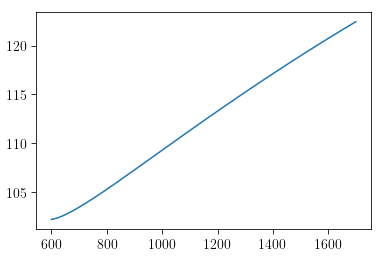

In [90]:
plt.plot(depthArr,180-np.array(recAng))
# plt.xlim(600,650)

# Compare to real data

# Dec 24

In [119]:
SpiceCore0 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh0_8_run_012559.pkl")
# SpiceCore0 = SpiceCore0.loc[(SpiceCore0.theta_reco>=90) & (SpiceCore0.power_H>0) & (SpiceCore0.power_V>0)]


SpiceCore1 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh1_9_run_012559.pkl")
# SpiceCore1 = SpiceCore1.loc[(SpiceCore1.theta_reco>=90) & (SpiceCore1.power_H>0) & (SpiceCore1.power_V>0)]

SpiceCore2 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh2_10_run_012559.pkl")
# SpiceCore2 = SpiceCore2.loc[(SpiceCore2.theta_reco>=90) & (SpiceCore2.power_H>0) & (SpiceCore2.power_V>0)]

SpiceCore3 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh3_11_run_012559.pkl")
# SpiceCore3 = SpiceCore3.loc[(SpiceCore3.theta_reco>=90) & (SpiceCore3.power_H>0) & (SpiceCore3.power_V>0)]

SpiceCore4 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh4_12_run_012559.pkl")
# SpiceCore4 = SpiceCore4.loc[(SpiceCore4.theta_reco>=90) & (SpiceCore4.power_H>0) & (SpiceCore4.power_V>0)]

SpiceCore5 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh5_13_run_012559.pkl")
# SpiceCore5 = SpiceCore5.loc[(SpiceCore5.theta_reco>=90) & (SpiceCore5.power_H>0) & (SpiceCore5.power_V>0)]

SpiceCore6 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh6_14_run_012559.pkl")
# SpiceCore6 = SpiceCore6.loc[(SpiceCore6.theta_reco>=90) & (SpiceCore6.power_H>0) & (SpiceCore6.power_V>0)]

In [120]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [121]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

In [122]:
SpiceCore0ForInterp = SpiceCore0.loc[(SpiceCore0.unixtime>min(SpiceCore0.unixtime)) & (SpiceCore0.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore0ForInterp.unixtime)
SpiceCore0ForInterp["interp_depth"] = interp_depth

SpiceCore1ForInterp = SpiceCore1.loc[(SpiceCore1.unixtime>min(SpiceCore1.unixtime)) & (SpiceCore1.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore1ForInterp.unixtime)
SpiceCore1ForInterp["interp_depth"] = interp_depth

SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

SpiceCore3ForInterp = SpiceCore3.loc[(SpiceCore3.unixtime>min(SpiceCore3.unixtime)) & (SpiceCore3.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore3ForInterp.unixtime)
SpiceCore3ForInterp["interp_depth"] = interp_depth

SpiceCore4ForInterp = SpiceCore4.loc[(SpiceCore4.unixtime>min(SpiceCore4.unixtime)) & (SpiceCore4.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore4ForInterp.unixtime)
SpiceCore4ForInterp["interp_depth"] = interp_depth

SpiceCore5ForInterp = SpiceCore5.loc[(SpiceCore5.unixtime>min(SpiceCore5.unixtime)) & (SpiceCore5.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore5ForInterp.unixtime)
SpiceCore5ForInterp["interp_depth"] = interp_depth

SpiceCore6ForInterp = SpiceCore6.loc[(SpiceCore6.unixtime>min(SpiceCore6.unixtime)) & (SpiceCore6.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore6ForInterp.unixtime)
SpiceCore6ForInterp["interp_depth"] = interp_depth

In [123]:
X_pol = 0.1#Fraction of crosspol

In [124]:
SpiceCore0ForInterp["R"] = np.sqrt((SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise)/(SpiceCore0ForInterp.power_V-SpiceCore0ForInterp.powerV_noise))
SpiceCore0ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore0ForInterp.theta_reco))/np.sqrt(1+SpiceCore0ForInterp.R**2)))
SpiceCore0ForInterp["R2"] = np.sqrt((SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise)/(SpiceCore0ForInterp.power_V-SpiceCore0ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore0ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore0ForInterp.theta_reco))/np.sqrt(1+SpiceCore0ForInterp.R2**2)))

SpiceCore1ForInterp["R"] = np.sqrt((SpiceCore1ForInterp.power_H-SpiceCore1ForInterp.powerH_noise)/(SpiceCore1ForInterp.power_V-SpiceCore1ForInterp.powerV_noise))
SpiceCore1ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore1ForInterp.theta_reco))/np.sqrt(1+SpiceCore1ForInterp.R**2)))
SpiceCore1ForInterp["R2"] = np.sqrt((SpiceCore1ForInterp.power_H-SpiceCore1ForInterp.powerH_noise)/(SpiceCore1ForInterp.power_V-SpiceCore1ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore1ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore1ForInterp.theta_reco))/np.sqrt(1+SpiceCore1ForInterp.R2**2)))


SpiceCore2ForInterp["R"] = np.sqrt((SpiceCore2ForInterp.power_H-SpiceCore2ForInterp.powerH_noise)/(SpiceCore2ForInterp.power_V-SpiceCore2ForInterp.powerV_noise))
SpiceCore2ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore2ForInterp.theta_reco))/np.sqrt(1+SpiceCore2ForInterp.R**2)))
SpiceCore2ForInterp["R2"] = np.sqrt((SpiceCore2ForInterp.power_H-SpiceCore2ForInterp.powerH_noise)/(SpiceCore2ForInterp.power_V-SpiceCore2ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore2ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore2ForInterp.theta_reco))/np.sqrt(1+SpiceCore2ForInterp.R2**2)))

SpiceCore3ForInterp["R"] = np.sqrt((SpiceCore3ForInterp.power_H-SpiceCore3ForInterp.powerH_noise)/(SpiceCore3ForInterp.power_V-SpiceCore3ForInterp.powerV_noise))
SpiceCore3ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore3ForInterp.theta_reco))/np.sqrt(1+SpiceCore3ForInterp.R**2)))
SpiceCore3ForInterp["R2"] = np.sqrt((SpiceCore3ForInterp.power_H-SpiceCore3ForInterp.powerH_noise)/(SpiceCore3ForInterp.power_V-SpiceCore3ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore3ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore3ForInterp.theta_reco))/np.sqrt(1+SpiceCore3ForInterp.R2**2)))

SpiceCore4ForInterp["R"] = np.sqrt((SpiceCore4ForInterp.power_H-SpiceCore4ForInterp.powerH_noise)/(SpiceCore4ForInterp.power_V-SpiceCore4ForInterp.powerV_noise))
SpiceCore4ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore4ForInterp.theta_reco))/np.sqrt(1+SpiceCore4ForInterp.R**2)))
SpiceCore4ForInterp["R2"] = np.sqrt((SpiceCore4ForInterp.power_H-SpiceCore4ForInterp.powerH_noise)/(SpiceCore4ForInterp.power_V-SpiceCore4ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore4ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore4ForInterp.theta_reco))/np.sqrt(1+SpiceCore4ForInterp.R2**2)))

SpiceCore5ForInterp["R"] = np.sqrt((SpiceCore5ForInterp.power_H-SpiceCore5ForInterp.powerH_noise)/(SpiceCore5ForInterp.power_V-SpiceCore5ForInterp.powerV_noise))
SpiceCore5ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore5ForInterp.theta_reco))/np.sqrt(1+SpiceCore5ForInterp.R**2)))
SpiceCore5ForInterp["R2"] = np.sqrt((SpiceCore5ForInterp.power_H-SpiceCore5ForInterp.powerH_noise)/(SpiceCore5ForInterp.power_V-SpiceCore5ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore5ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore5ForInterp.theta_reco))/np.sqrt(1+SpiceCore5ForInterp.R2**2)))


SpiceCore6ForInterp["R"] = np.sqrt((SpiceCore6ForInterp.power_H-SpiceCore6ForInterp.powerH_noise)/(SpiceCore6ForInterp.power_V-SpiceCore6ForInterp.powerV_noise))
SpiceCore6ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore6ForInterp.theta_reco))/np.sqrt(1+SpiceCore6ForInterp.R**2)))
SpiceCore6ForInterp["R2"] = np.sqrt((SpiceCore6ForInterp.power_H-SpiceCore6ForInterp.powerH_noise)/(SpiceCore6ForInterp.power_V-SpiceCore6ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore6ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore6ForInterp.theta_reco))/np.sqrt(1+SpiceCore6ForInterp.R2**2)))


# SpiceCore0ForInterp = SpiceCore0ForInterp.dropna()
# SpiceCore1ForInterp = SpiceCore1ForInterp.dropna()
# SpiceCore2ForInterp = SpiceCore2ForInterp.dropna()
# SpiceCore3ForInterp = SpiceCore3ForInterp.dropna()
# SpiceCore4ForInterp = SpiceCore4ForInterp.dropna()
# SpiceCore5ForInterp = SpiceCore5ForInterp.dropna()
# SpiceCore6ForInterp = SpiceCore6ForInterp.dropna()

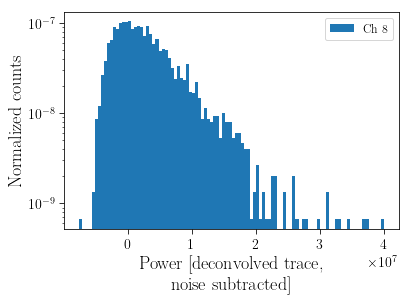

In [125]:
plt.hist(SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise, bins = 100, density=True, label = "Ch 8");
# plt.axvline(SpiceCore0ForInterp.powerH_noise.unique()[0], c = "red", label = "Soft-triggers avg. noise power")
plt.yscale('log')
plt.xlabel("Power [deconvolved trace, \n noise subtracted]")
plt.ylabel("Normalized counts")
plt.legend()

In [126]:
SpiceCore0ForInterp.powerH_noise.unique()[0]

7515525.90979793

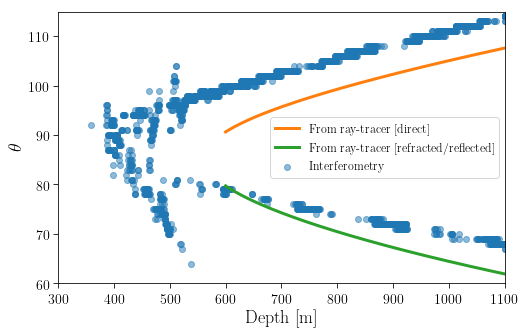

In [145]:
plt.figure(figsize=(8,5))
plt.plot(depthArr,180-np.array(recAng[0]), c = "C1", lw = 3,label = "From ray-tracer [direct]")
plt.plot(depthArr,180-np.array(recAng[1]), c = "C2", lw = 3,label = "From ray-tracer [refracted/reflected]")

plt.scatter(SpiceCore0ForInterp.interp_depth, SpiceCore0ForInterp.theta_reco, label="Interferometry", alpha = 0.5)
plt.xlim(300,1100)
plt.ylim(60,115)

plt.ylabel("$\\theta$")
plt.xlabel("Depth [m]")
plt.legend()